## Data Preparation

In [1]:
import pandas as pd
train_df = pd.read_csv('/kaggle/input/hms-harmful-brain-activity-classification/train.csv')
display(train_df.tail())

print(f'\n# of Unique EEG: {len(train_df.eeg_id.unique())}')
print(f'# of Unique Spectrogram: {len(train_df.spectrogram_id.unique())}')
print(f'# of Unique Patients: {len(train_df.patient_id.unique())}')

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
106795,351917269,6,12.0,2147388374,6,12.0,4195677307,10351,LRDA,0,0,0,3,0,0
106796,351917269,7,14.0,2147388374,7,14.0,290896675,10351,LRDA,0,0,0,3,0,0
106797,351917269,8,16.0,2147388374,8,16.0,461435451,10351,LRDA,0,0,0,3,0,0
106798,351917269,9,18.0,2147388374,9,18.0,3786213131,10351,LRDA,0,0,0,3,0,0
106799,351917269,10,20.0,2147388374,10,20.0,3642716176,10351,LRDA,0,0,0,3,0,0



# of Unique EEG: 17089
# of Unique Spectrogram: 11138
# of Unique Patients: 1950


**Observations:**

1. <span style="color:darkgreen">Multiple eeg_ids may have the same spectrogram_id.</span>
2. <span style="color:darkgreen">Same eeg_id may have the multiple targets.</span>
3. <span style="color:darkgreen">There can be different targets for the same spectrogram_id depending on the time intervals during which they were observed.</span>

For each ***unique target in eeg_id***, Let's get corresponding *spectrogram_id* along with the time interval (min and max of spectrogram_label_offset_seconds) during which a specific brain activity was detected.

a.k.a **<span style="color:darkgreen"> Preprocessing</span>**

In [2]:
# Group by 'eeg_id' and targets compute the minimum and maximum values of 'spectrogram_label_offset_seconds'
group_by_cols = [
    'eeg_id', 'seizure_vote', 'lpd_vote',
    'gpd_vote', 'lrda_vote', 'grda_vote',
    'other_vote'
]

temp1 = train_df.groupby(group_by_cols).agg(
    min_offset_eeg=("eeg_label_offset_seconds", "min"),
    max_offset_eeg=("eeg_label_offset_seconds", "max"),
    min_offset_spec=("spectrogram_label_offset_seconds", "min"),
    max_offset_spec=("spectrogram_label_offset_seconds", "max")
).reset_index()


# Columns to Aggregate by first value
columns_to_keep = [
    'spectrogram_id', 'patient_id', 'expert_consensus', 'label_id'
    #'seizure_vote', 'lpd_vote','gpd_vote',
    #'lrda_vote', 'grda_vote', 'other_vote'
]

temp2 = train_df.groupby(group_by_cols)[columns_to_keep].agg('first')

# Merge based on the 'eeg_id' and targets
train_df = pd.merge(temp1, temp2, on=group_by_cols, how='inner')

# Convert targets into probabilities.
TARGETS = [
    'seizure_vote', 'lpd_vote', 'gpd_vote',
    'lrda_vote', 'grda_vote', 'other_vote'
]
row_sum = train_df[TARGETS].sum(axis=1)
train_df[TARGETS] = train_df[TARGETS].div(row_sum, axis=0)
train_df['total_votes'] = row_sum

# Rename the expert_consensus column to target.
train_df.rename(columns={'expert_consensus': 'target'}, inplace=True)

# Display
display(train_df.tail(5))

# Perform garbage collection
import gc

del temp1, temp2, row_sum
gc.collect()

,eeg_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,min_offset_eeg,max_offset_eeg,min_offset_spec,max_offset_spec,spectrogram_id,patient_id,target,label_id,total_votes
20178,4293354003,0.0,0.0,0.0,0.0,0.500000,0.500000,0.0,0.0,0.0,0.0,1188113564,16610,GRDA,447244163,2
20179,4293843368,0.0,0.0,0.0,0.0,0.500000,0.500000,0.0,0.0,0.0,0.0,1549502620,15065,GRDA,1618953053,2
20180,4294455489,0.0,0.0,0.0,0.0,0.000000,1.000000,0.0,0.0,0.0,0.0,2105480289,56,Other,469526364,1
20181,4294858825,0.0,0.0,0.0,0.0,0.066667,0.933333,0.0,12.0,0.0,12.0,657299228,4312,Other,561576493,15
20182,4294958358,0.0,0.0,0.0,0.0,0.000000,1.000000,0.0,0.0,2508.0,2508.0,260520016,25986,Other,2788887007,2


0

Total unique Training data based on the ***eeg_id and targets*** are: **20183**

Since i am going to train the model on Spectrogram images (Following the footsteps of [CHRIS DEOTTE](https://www.kaggle.com/code/cdeotte/efficientnetb2-starter-lb-0-57/notebook) and [TAWARA](https://www.kaggle.com/code/ttahara/hms-hbac-resnet34d-baseline-training/)), Lets read a spectrogram file and convert it to image to see how it looks.

a.k.a **<span style="color:darkgreen"> Visualization</span>**

Before this, Let me drop few quick knowledge bombs for better digestion of the things :p

1. **The spectrogram can be seen as a three-way plot of time on the x axis, frequency on the y axis, and power as color. [[Link]](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8901534/)**

2. **Each spectrogram image has four panels: left lateral (LL), right lateral (RL), left parasagittal (LP), right parasagittal (RP).[[Link]](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7461156/) Each panel will correspond to 1 image so for a single spectrogram, we have a total of 4 images.**

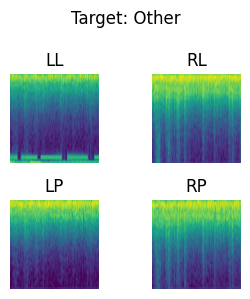

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

# Randomly sample a row from df
sample_row = train_df.sample(1)
spec_id = sample_row.iloc[0]['spectrogram_id']    
target = sample_row.iloc[0]['target']

# Read spectrogram file
spec = pd.read_parquet(f'/kaggle/input/hms-harmful-brain-activity-classification/train_spectrograms/{spec_id}.parquet')
spec_arr = spec.fillna(0).values[:, 1:].T.astype("float32") # Fill nan value with zero

# Let's get the image for each panel.
PANELS = ['LL', 'RL', 'LP', 'RP']

# Calculate the number of rows and columns for the subplot
num_rows = 2
num_cols = 2

# Adjust the figsize accordingly
fig, ax = plt.subplots(num_rows, num_cols, figsize=(3, 3))

# Flatten the axes array if needed for easy indexing
ax = ax.flatten()

for (idx, panel) in enumerate(PANELS):
    img = spec_arr[100 * idx: 100 * idx + 100, :]

    # log transform (Taken from TAWARA Notebook)
    img = np.clip(img, np.exp(-4), np.exp(8))
    img = np.log(img)

    # normalize per image
    eps = 1e-6
    img_mean = img.mean(axis=(0, 1))
    img = img - img_mean
    img_std = img.std(axis=(0, 1))
    img = img / (img_std + eps)
    
    # Resize for visualize purpose
    img = cv2.resize(img, (128, 128))

    # Plot
    ax[idx].imshow(img)
    ax[idx].set_title(f'{panel}')
    ax[idx].axis('off')

fig.suptitle(f'Target: {target}', fontsize=12)

# Adjust layout for better spacing
plt.tight_layout()

It's upto us that how do we like to process these images. i.e, Vertical/ Horizontal/ 2H-2V stack.

Let's prepare the data for training by splitting it into 5-folds for submission. We'll allocate the data to each fold based on the **patient_id**.

**Code Reference:**  [HMS-HBAC: ResNet34d Baseline [Training]](https://www.kaggle.com/code/ttahara/hms-hbac-resnet34d-baseline-training/)

In [4]:
from sklearn.model_selection import StratifiedGroupKFold
N_FOLDS = 5
RANDAM_SEED = 42

sgkf = StratifiedGroupKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDAM_SEED)

train_df["fold"] = -1

for fold_id, (_, val_idx) in enumerate(
    sgkf.split(train_df, y=train_df["target"], groups=train_df["patient_id"])
):
    train_df.loc[val_idx, "fold"] = fold_id
    
# Display
display(train_df.tail(5))

print('\nFoldwise Training Data: \n')
print(train_df['fold'].value_counts())

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


,eeg_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,min_offset_eeg,max_offset_eeg,min_offset_spec,max_offset_spec,spectrogram_id,patient_id,target,label_id,total_votes,fold
20178,4293354003,0.0,0.0,0.0,0.0,0.500000,0.500000,0.0,0.0,0.0,0.0,1188113564,16610,GRDA,447244163,2,1
20179,4293843368,0.0,0.0,0.0,0.0,0.500000,0.500000,0.0,0.0,0.0,0.0,1549502620,15065,GRDA,1618953053,2,0
20180,4294455489,0.0,0.0,0.0,0.0,0.000000,1.000000,0.0,0.0,0.0,0.0,2105480289,56,Other,469526364,1,1
20181,4294858825,0.0,0.0,0.0,0.0,0.066667,0.933333,0.0,12.0,0.0,12.0,657299228,4312,Other,561576493,15,2
20182,4294958358,0.0,0.0,0.0,0.0,0.000000,1.000000,0.0,0.0,2508.0,2508.0,260520016,25986,Other,2788887007,2,3



Foldwise Training Data: 

fold
1    4372
4    4279
3    4268
2    3685
0    3579
Name: count, dtype: int64


In [5]:
train_4_votes = train_df[train_df['total_votes'] == 4].reset_index(drop=True)

# 100% Votes to a single class
selected_indices = train_4_votes[train_4_votes[TARGETS].eq(1.0).any(axis=1)].index
train_4_votes_conf = train_4_votes.loc[selected_indices].reset_index(drop=True)

# Distributed class
train_4_votes_not_conf = train_4_votes.drop(selected_indices).reset_index(drop=True)

print(f'Total samples with votes=4: {len(train_4_votes)}')
print(f'Samples with 100% confidence: {len(train_4_votes_conf)}')
print(f'Samples with <100% confidence: {len(train_4_votes_not_conf)}')

Total samples with votes=4: 752
Samples with 100% confidence: 156
Samples with <100% confidence: 596


In [6]:
# less than 5 votes
train_stage_1 = train_df[train_df['total_votes'] < 4].reset_index(drop=True)

# Add <100% Confidence samples
train_stage_1 = pd.concat([train_stage_1, 
                           train_4_votes_not_conf
                          ]).reset_index(drop=True)
print(train_stage_1['fold'].value_counts())
train_stage_1.tail()

fold
4    2607
1    2582
3    2566
2    2347
0    2288
Name: count, dtype: int64


,eeg_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,min_offset_eeg,max_offset_eeg,min_offset_spec,max_offset_spec,spectrogram_id,patient_id,target,label_id,total_votes,fold
12385,4257527824,0.00,0.25,0.75,0.00,0.00,0.00,0.0,6.0,0.0,6.0,873216205,21996,GPD,3979164914,4,0
12386,4259611423,0.00,0.00,0.50,0.00,0.00,0.50,0.0,18.0,540.0,558.0,147073069,40881,GPD,1688269893,4,3
12387,4276652062,0.00,0.25,0.00,0.00,0.00,0.75,0.0,6.0,0.0,6.0,1585815557,48899,Other,3200007882,4,1
12388,4284659653,0.00,0.00,0.00,0.00,0.25,0.75,0.0,2.0,2696.0,2698.0,1841034439,32481,Other,2080594355,4,1
12389,4284659653,0.25,0.00,0.00,0.25,0.00,0.50,42.0,46.0,2738.0,2742.0,1841034439,32481,Other,1746250238,4,1


In [7]:
# 5 or more votes
train_stage_2 = train_df[train_df['total_votes'] >= 5].reset_index(drop=True)

# Add <100% Confidence samples
train_stage_2 = pd.concat([train_stage_2,
                           train_4_votes_conf
                          ]).reset_index(drop=True)
print(train_stage_2['fold'].value_counts())
train_stage_2.tail()

fold
1    1790
3    1702
4    1672
2    1338
0    1291
Name: count, dtype: int64


,eeg_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,min_offset_eeg,max_offset_eeg,min_offset_spec,max_offset_spec,spectrogram_id,patient_id,target,label_id,total_votes,fold
7788,4205804805,0.0,1.0,0.0,0.0,0.0,0.0,92.0,94.0,1318.0,1320.0,66386607,29441,LPD,1018069011,4,1
7789,4209971814,0.0,1.0,0.0,0.0,0.0,0.0,0.0,112.0,0.0,112.0,777367952,1218,LPD,1457944506,4,1
7790,4210157368,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,406.0,406.0,1994841981,6489,Other,2811390818,4,4
7791,4224679683,0.0,1.0,0.0,0.0,0.0,0.0,0.0,34.0,5356.0,5390.0,1863712617,35225,LPD,831260890,4,2
7792,4258717543,0.0,1.0,0.0,0.0,0.0,0.0,0.0,64.0,306.0,370.0,1682146264,55021,LPD,1263458080,4,4


We are going to use spectrogram for training, It is not efficient to read the spectrogram parquet_file every time during training so let's save all spectrograms in an array. But we don't even need to do that. Thanks to [CHRIS DEOTTE](https://www.kaggle.com/datasets/cdeotte/brain-spectrograms) for his amazing Dataset.

In [8]:
# READ ALL SPECTROGRAMS
spectrograms = np.load('/kaggle/input/brain-spectrograms/specs.npy',allow_pickle=True).item()
print(f'# of Total Spectrograms: {len(spectrograms)}')

# of Total Spectrograms: 11138


## Utilities

Let's write the Pytorch Dataset Class.

In [9]:
import torch
from torch.utils.data import Dataset

# Global Mean + STD
MEAN = -0.08340271
STD = 1.9072835

MEAN_G = 0.07975473
STD_G = 1.9484872

class HBACDataset(Dataset):

    def __init__(self,
                 df,
                 specs = spectrograms,
                 mode = 'train',
                 transform = None, # Augmentations
                ):
        self.df = df
        self.specs = specs
        self.mode = mode
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    
    '''Normalize the Spectrogram Image'''
    # Mean + Std from global Data.
    def _normalize(self, img, m, s):
        # LOG TRANSFORM SPECTROGRAM
        img = np.clip(img, np.exp(-4), np.exp(8))
        img = np.log(img)
        # STANDARDIZE PER IMAGE
        ep = 1e-6
        img = (img - m) / (s + ep)
        img = np.nan_to_num(img, nan=0.0)
        return img

    def __getitem__(self, idx):
        
        # Get the Spectrogram Interval of the Particular Activity.
        minimum = self.df['min_offset_spec'].iloc[idx]
        maximum = self.df['max_offset_spec'].iloc[idx]
        
        r = int( (minimum + maximum)//4 )
        
        # Spectrogram ID
        spec_id = self.df.iloc[idx]['spectrogram_id']
        
        input_img = []
        for k in range(4):
            # EXTRACT 300 ROWS OF SPECTROGRAM
            img = self.specs[spec_id][r:r+300,k*100:(k+1)*100].T
            input_img.append(img)

        input_img = np.vstack(input_img)
        input_img = self._normalize(input_img, m=MEAN, s=STD)
            
        #input_img = self._localImgFeatures(input_img)
        
        input_img = input_img[..., None] # Hz x Time x Channel

        if self.transform is not None:
            input_img = self.transform(image=input_img)["image"]


        labels = self.df.iloc[idx][TARGETS].values.astype(np.float32)
        total_votes = self.df.iloc[idx]['total_votes'].astype(np.float32)

        return {"data": input_img,
                "target": torch.tensor(labels),
                "total_votes": torch.tensor(total_votes)
               }

Let's create a model that we are going to use for Training. 

* Among the shared code within the community for this competition, **ResNet34 and EfficientNet** emerge as the most prominent models with the highest public score notebooks.

* We'll start our exploration with these models.

**Code Reference:**  [HMS-HBAC: ResNet34d Baseline [Training]](https://www.kaggle.com/code/ttahara/hms-hbac-resnet34d-baseline-training/)

In [10]:
import timm
import torch.nn as nn

class HBACSpecModel(nn.Module):
    
    def __init__(
        self,
        model_name: str,
        pretrained: bool,
        in_channels: int,
        num_classes: int,
        drop_path_rate: float,
        drop_rate: float
    ):
        
        super().__init__()
        self.model = timm.create_model(
            model_name=model_name, 
            pretrained=pretrained,
            num_classes=num_classes, 
            in_chans=in_channels, 
            drop_path_rate = drop_path_rate
        )
        
        # Input Features
        in_features = self.model.classifier.in_features
        
        # Add Dropout
        self.model.classifier = nn.Sequential(
            nn.Dropout(drop_rate),
            nn.Linear(in_features, num_classes, bias=True)
        )
        
    def forward(self, x):
        x = self.model(x)      
        return x

Since KLDivLoss align with the competition metric, we will use KLDiv Loss as Loss Function.

In [11]:
class KLDivLossWithLogits(nn.KLDivLoss):

    def __init__(self):
        super().__init__(reduction="none")  # Set reduction to "none" to return individual losses

    def forward(self, 
                y, 
                t, 
                total_votes = None, 
                weights=None
               ):
        
        y = nn.functional.log_softmax(y, dim=1)
        loss = super().forward(y, t)

        # Sum along samples
        loss = torch.sum(loss, dim=1)
        
        # Take Total votes in account
        if total_votes is not None:
            #loss = loss * torch.log(total_votes + 1)
            loss = loss * total_votes
        
        # Apply sample weights if provided
        if weights is not None:
            loss = loss * weights
        
        return torch.mean(loss)  # Calculate mean loss over the batch

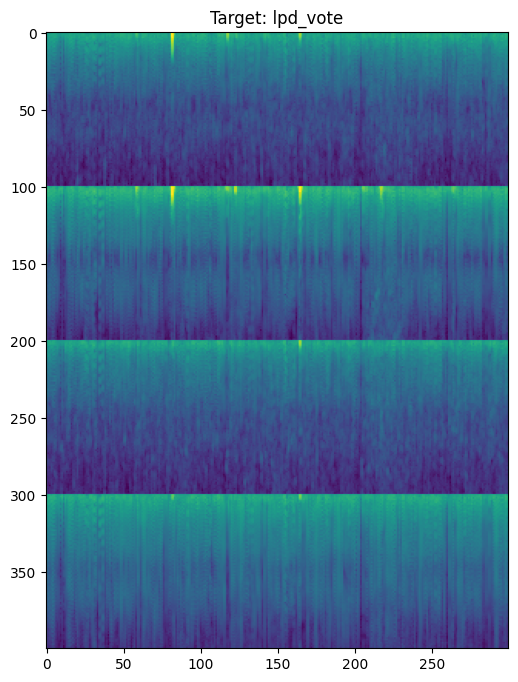

3583

In [12]:
# Test
import random

# Initialize Dataset Class
ds = HBACDataset(train_df)

# Get a sample
sample = ds[random.randint(0, len(ds))]

# Get Data and Label from sample
data = sample['data']
label = TARGETS[sample['target'].argmax().item()]

# Plot
plt.figure(figsize=(8, 8))
plt.imshow(data)
plt.title(f'Target: {label}')
plt.show()

# Garbage Collection
del ds, data, label
gc.collect()

## Mosaic Augmentation

In [13]:
def hbac_mosaic(data, target):
    
    # Aggregate the Features.
    batch_size = data.size(0)
    img_local_feats = torch.zeros(batch_size, 1, data.size(2), 75)

    for batch_idx in range(batch_size):
        img = data[batch_idx]
        for i in range(75):
            mean = torch.mean(img[0, :, 4*i: 4*i+4], dim=1)
            img_local_feats[batch_idx, 0, :, i] = mean
           
            
    # Mosaic Logic
    mosaic_img = data.clone()
    mosaic_targets = torch.zeros(target.shape)
    #mosaic_total_votes = torch.zeros(total_votes.shape)
    
    batches_idx = np.random.randint(0, batch_size, (batch_size, 4))
    #print(batches_idx)
    for (idx, idxs) in enumerate(batches_idx):
        img = img_local_feats[idxs]
        img = torch.cat([img[i] for i in range(img.shape[0])], dim=2)
        mosaic_img[idx] = img
        mosaic_targets[idx] = torch.mean(target[idxs], dim=0)
            
    return mosaic_img, mosaic_targets

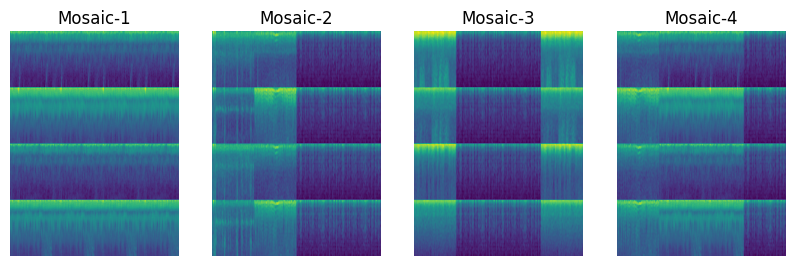

55

In [14]:
# Initialize Dataset Class
from torch.utils.data import DataLoader

#test_df = train_df[train_df['seizure_vote'] >= 0.50].reset_index(drop=True)
ds = HBACDataset(train_df)
dl = DataLoader(ds, batch_size=8, shuffle=True)

for (batch_idx, batch) in enumerate(dl):
    inputs = batch['data']
    inputs = inputs.squeeze(3).unsqueeze(1)
   # print(inputs.shape)
    labels = batch['target']
    total_votes = batch['total_votes']
    # Mosaic
    mosaic_data, target = hbac_mosaic(inputs, labels)
    break
#print(total_votes, mosaic_total_votes)


f, ax = plt.subplots(1, 4, figsize=(10, 10))
# Assuming you have a list of four images img_list
for i in range(4):
    ax[i].imshow(mosaic_data[i][0, :, :])  # Assuming img_list contains images in the format accepted by imshow
    ax[i].axis('off')  # Turn off axis
    ax[i].set_title(f'Mosaic-{i+1}')
plt.show()

# Garbage Collection
del ds, dl, inputs, labels, mosaic_data, target
gc.collect()

## Training

### Stage-1

Training with the **total_votes < 4**

In [18]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
from torch.nn.parallel import DataParallel
from torch import optim
from torch.optim import lr_scheduler

# Check if GPU is available.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'DEVICE: {device}\n')

# Transformations
train_transform = A.Compose([
    ToTensorV2(p=1.0)
])

val_transform = A.Compose([
    ToTensorV2(p=1.0)
])
    
# Loop through all folds. (5-Fold)
for fold in range(5):
    print('----------------------------------------------------------')
    print(f'\nFold: {fold}')
    
    # Train-Valid Split for the Fold
    train = train_stage_1[train_stage_1['fold'] != fold].reset_index(drop=True)
    valid = train_stage_1[train_stage_1['fold'] == fold].reset_index(drop=True)
    
    # Dataset
    train_ds = HBACDataset(train, transform=train_transform, mode='train')
    valid_ds = HBACDataset(valid, transform=val_transform, mode='valid')

    print(f'Train - {len(train_ds)}, Test - {len(valid_ds)}')
    
    # Dataloader
    batch_size = 32
    train_dataloader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    valid_dataloader = DataLoader(valid_ds, batch_size=batch_size, shuffle=False)
    
    # Initialize the Model
    model = HBACSpecModel(model_name='efficientnet_b0', 
                          pretrained=True, 
                          in_channels=1, 
                          num_classes=6,
                          drop_path_rate = 0.2,
                          drop_rate = 0.3
                         )
    
    # Used for Mixed Precision Training
    scaler = GradScaler()

    # Move your model to the GPU and wrap it with DataParallel (To utilize T4X2)
    model = model.to(device)
    model = DataParallel(model)
    
    # Loss Function
    loss_func = KLDivLossWithLogits()

    # Prepare optimizer
    optimizer = optim.AdamW(model.parameters(),
                            lr=1.0e-03,
                            weight_decay = 1.0e-02
                           )
    NUM_EPOCHS = 6
    MOSAIC_WARMUP_EPOCHS = 2

    # 1cycle policy
    scheduler = lr_scheduler.OneCycleLR(
            optimizer=optimizer, epochs=NUM_EPOCHS,
            pct_start=0.0, steps_per_epoch=len(train_dataloader),
            max_lr=1.0e-03, div_factor=25, final_div_factor=4.0e-01
        )

    best_eval_loss = float('inf')  # Initialize the best evaluation loss to infinity

    # Do Evaluation 2 Times in every Epochs
    doEval = False
    eval_step = len(train_dataloader)//2 - 1
    
    print('\n----------------------------------------------------')
    print(f'\033[93mEpoch    Step     Mosaic    Train-Loss   Valid-Loss\033[0m')
    print('----------------------------------------------------')
    
    for epoch in range(NUM_EPOCHS):
        
        total_loss = 0
        mosaic = False
        
        for (batch_idx, batch) in enumerate(train_dataloader):
            model.train() # Set the model to Training mode
            with autocast():
                inputs = batch['data'].to(device)
                labels = batch['target'].to(device)
                total_votes = batch['total_votes'].to(device)
            
                # Clamp to 10
                total_votes = torch.clamp(total_votes, max=10)
                #total_votes[total_votes == 10] = 2*10
                #print(total_votes)
                
                # Mosaic Augmentations for 3 Epochs
                if epoch < MOSAIC_WARMUP_EPOCHS:
                    inputs, labels = hbac_mosaic(inputs, labels)
                    labels = labels.to(device)
                    mosaic = True
                        

                # Forward loop
                optimizer.zero_grad() # Ensures Gradient doesn't accumulate.

                predictions = model(inputs.float())

                # Compute KLDIV loss
                total_votes = total_votes if epoch >=MOSAIC_WARMUP_EPOCHS else None
                loss = loss_func(predictions, labels, total_votes=total_votes)

            # BackProp
            scaler.scale(loss).backward()  # Scale the loss value
            scaler.step(optimizer)
            scaler.update()

            # Accumulate the Loss
            total_loss += loss.item()

            if (batch_idx != 0) and (batch_idx%eval_step == 0):
                # Calculate epoch-level metrics
                epoch_loss = total_loss / len(train_dataloader)

                # Evaluation
                model.eval()  # Set model to evaluation mode
                eval_loss = 0

                with torch.no_grad():
                    for batch in valid_dataloader:
                        with autocast():
                            inputs = batch['data'].to(device)
                            labels = batch['target'].to(device)
                            #total_votes = batch['total_votes'].to(device)
                                
                            # Mosaic Augmentations for 3 Epochs
                            if epoch < MOSAIC_WARMUP_EPOCHS:
                                inputs, labels = hbac_mosaic(inputs, labels)
                                labels = labels.to(device)

                            predictions = model(inputs.float())
                            loss = loss_func(predictions, labels)

                            eval_loss += loss.item()

                # Calculate evaluation metrics
                eval_epoch_loss = eval_loss / len(valid_dataloader)

                print(f'{epoch+1:<10} {(batch_idx//eval_step):<8} {str(mosaic):<8} {epoch_loss:<10.4f}', end = "   ")

                # Save the Best Model
                if eval_epoch_loss < best_eval_loss:
                    best_eval_loss = eval_epoch_loss
                    print(f'\033[32m{best_eval_loss:<10.4f}\033[0m')
                    # Access the actual model from the DataParallel object
                    actual_model = model.module
                    # Save
                    torch.save(actual_model, f'fold_{fold}.pth')

                else:
                    print(f'\033[31m{eval_epoch_loss:<10.4f}\033[0m')
                    
        if epoch == (MOSAIC_WARMUP_EPOCHS-1):
            best_eval_loss = float('inf') # Reset
                        
                        
    # Memory Management
    del train_ds, valid_ds, train_dataloader, valid_dataloader, model, actual_model
    gc.collect()
    torch.cuda.empty_cache()

DEVICE: cuda

----------------------------------------------------------

Fold: 0
Train - 10102, Test - 2288

----------------------------------------------------
Epoch    Step     Mosaic    Train-Loss   Valid-Loss
----------------------------------------------------
1          1        True     0.2601       0.4600    
1          2        True     0.4847       0.4747    
2          1        True     0.2125       0.4026    
2          2        True     0.4217       0.4770    
3          1        False    1.1201       0.9168    
3          2        False    2.0474       0.7863    
4          1        False    0.8223       0.7688    
4          2        False    1.6115       0.7904    
5          1        False    0.7052       0.8430    
5          2        False    1.3968       0.8168    
6          1        False    0.6364       0.8283    
6          2        False    1.2621       0.8193    
----------------------------------------------------------

Fold: 1
Train - 9808, Test - 2582

-

In [ ]:
# Effb0 + GlobalP + Stage-1
# Fold-1: 0.7279    0.7688    
# Fold-2: 0.7914    0.7986        
# Fold-3: 0.7714    0.7539        
# Fold-4: 0.9612    0.8901    
# Fold-5: 0.7834    0.7473     

### Stage-2

* Training with the **total_votes >= 5 samples**
* Use Transfer learning from previous stage models.

In [33]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
from torch.nn.parallel import DataParallel
from torch import optim
from torch.optim import lr_scheduler

# Check if GPU is available.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'DEVICE: {device}\n')

# Transformations
train_transform = A.Compose([
    ToTensorV2(p=1.0)
])

val_transform = A.Compose([
    ToTensorV2(p=1.0)
])
    
# Loop through all folds. (5-Fold)
for fold in range(5):
    print('----------------------------------------------------------')
    print(f'\nFold: {fold}')
    
    # Train-Valid Split for the Fold
    train = train_stage_2[train_stage_2['fold'] != fold].reset_index(drop=True)
    valid = train_stage_2[train_stage_2['fold'] == fold].reset_index(drop=True)
    
    # Dataset
    train_ds = HBACDataset(train, transform=train_transform, mode='train')
    valid_ds = HBACDataset(valid, transform=val_transform, mode='valid')

    print(f'Train - {len(train_ds)}, Test - {len(valid_ds)}')
    
    # Dataloader
    batch_size = 32
    train_dataloader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    valid_dataloader = DataLoader(valid_ds, batch_size=batch_size, shuffle=False)
    
    # Use Stage-1 Pretrained Model
    model = torch.load(f'/kaggle/input/hbac-effb4-models/effb0_stage_1_3_or_less/effb0_stage_1_3_or_less/fold_{fold}.pth')
    
    # Used for Mixed Precision Training
    scaler = GradScaler()

    # Move your model to the GPU and wrap it with DataParallel (To utilize T4X2)
    model = model.to(device)
    model = DataParallel(model)
    
    # Loss Function
    loss_func = KLDivLossWithLogits()

    # Prepare optimizer
    optimizer = optim.AdamW(model.parameters(),
                            lr=1.0e-03,
                            weight_decay = 1.0e-02
                           )
    NUM_EPOCHS = 6

    # 1cycle policy
    scheduler = lr_scheduler.OneCycleLR(
            optimizer=optimizer, epochs=NUM_EPOCHS,
            pct_start=0.0, steps_per_epoch=len(train_dataloader),
            max_lr=1.0e-03, div_factor=25, final_div_factor=4.0e-01
        )

    best_eval_loss = float('inf')  # Initialize the best evaluation loss to infinity

    # Do Evaluation 2 Times in every Epochs
    doEval = False
    eval_step = len(train_dataloader)//2 - 1
    
    print('\n----------------------------------------------')
    print(f'\033[93mEpoch    Step    Train-Loss   Valid-Loss\033[0m')
    print('----------------------------------------------')
    
    for epoch in range(NUM_EPOCHS):
        
        total_loss = 0
        
        for (batch_idx, batch) in enumerate(train_dataloader):
            model.train() # Set the model to Training mode
            with autocast():
                inputs = batch['data'].to(device)
                labels = batch['target'].to(device)
                total_votes = batch['total_votes'].to(device)
            
                # Clamp to 10
                #total_votes = torch.clamp(total_votes, max=10)
                #total_votes[total_votes == 10] = 2*10
                
                # Weight assigning strategy
                mask = total_votes > 10
                margin = torch.log10(total_votes[mask].float())
                replacement = (10 + 2 * margin) * margin
                total_votes[mask] = replacement
                #print(total_votes)
                        
                # Forward loop
                optimizer.zero_grad() # Ensures Gradient doesn't accumulate.

                predictions = model(inputs.float())

                # Compute KLDIV loss
                loss = loss_func(predictions, labels, total_votes=total_votes)

            # BackProp
            scaler.scale(loss).backward()  # Scale the loss value
            scaler.step(optimizer)
            scaler.update()

            # Accumulate the Loss
            total_loss += loss.item()

            if (batch_idx != 0) and (batch_idx%eval_step == 0):
                # Calculate epoch-level metrics
                epoch_loss = total_loss / len(train_dataloader)

                # Evaluation
                model.eval()  # Set model to evaluation mode
                eval_loss = 0

                with torch.no_grad():
                    for batch in valid_dataloader:
                        with autocast():
                            inputs = batch['data'].to(device)
                            labels = batch['target'].to(device)
                            #total_votes = batch['total_votes'].to(device)

                            predictions = model(inputs.float())
                            loss = loss_func(predictions, labels)

                            eval_loss += loss.item()

                # Calculate evaluation metrics
                eval_epoch_loss = eval_loss / len(valid_dataloader)

                print(f'{epoch+1:<10} {(batch_idx//eval_step):<8} {epoch_loss:<10.4f}', end = "   ")

                # Save the Best Model
                if eval_epoch_loss < best_eval_loss:
                    best_eval_loss = eval_epoch_loss
                    print(f'\033[32m{best_eval_loss:<10.4f}\033[0m')
                    # Access the actual model from the DataParallel object
                    actual_model = model.module
                    # Save
                    torch.save(actual_model, f'fold_{fold}.pth')

                else:
                    print(f'\033[31m{eval_epoch_loss:<10.4f}\033[0m')
                        
                        
    # Memory Management
    del train_ds, valid_ds, train_dataloader, valid_dataloader, model, actual_model
    gc.collect()
    torch.cuda.empty_cache()

DEVICE: cuda

----------------------------------------------------------

Fold: 0
Train - 6502, Test - 1291

----------------------------------------------
Epoch    Step    Train-Loss   Valid-Loss
----------------------------------------------
1          1        2.6506       0.4416    
1          2        4.8890       0.4543    
2          1        2.0703       0.5140    
2          2        4.1222       0.4481    
3          1        1.8867       0.4669    
3          2        3.7679       0.4408    
4          1        1.7394       0.4552    
4          2        3.4208       0.4560    
5          1        1.5163       0.4630    
5          2        3.1068       0.4483    
----------------------------------------------------------

Fold: 1
Train - 6003, Test - 1790

----------------------------------------------
Epoch    Step    Train-Loss   Valid-Loss
----------------------------------------------
1          1        2.5845       0.4391    
1          2        4.9166       0.4255   

In [13]:
## Effb0 + 2-Stage Training + Global Features

# Fold-1: 0.5989  0.3983 0.4303 0.4283  0.4283   0.4408     
# Fold-2: 0.5650  0.3682 0.3940 0.3932  0.4115   0.3903 
# Fold-3: 0.6054  0.3624 0.3911 0.3824  0.3995   0.3926    
# Fold-4: 0.6357  0.3808 0.4277 0.4119  0.4065   0.4162    
# Fold-5: 0.6259  0.3956 0.4222 0.4135  0.4346   0.4322
# OOF:    0.6062  0.3803 0.4145 0.4070  0.4142   0.4107
# LB:     0.37    0.38   0.36   0.34    0.34-   

## OOF-CV

In [34]:
from tqdm import tqdm

label_arr = train_stage_2[TARGETS].values
oof_pred_arr = np.zeros((len(train_stage_2), 6))

for fold in range(5):
    
    # Get valid Dataloader
    valid = train_stage_2[train_stage_2['fold'] == fold].reset_index()
    valid_ds = HBACDataset(valid, transform=val_transform, mode='valid')
    valid_dataloader = DataLoader(valid_ds, batch_size=32, shuffle=False)
    
    # Get Model
    model = torch.load(f'fold_{fold}.pth')
    
    # Run Inference
    model.to(device)
    model.eval()
    pred_list = []
    eval_loss = 0
    with torch.no_grad():
        for batch in tqdm(valid_dataloader):
            x = batch["data"].to(device)
            labels = batch['target'].to(device)
            y = model(x.float())
            loss = loss_func(y, labels)
            eval_loss += loss.item()
            pred_list.append(y.softmax(dim=1).detach().cpu().numpy())
            
    # Calculate evaluation metrics
    eval_epoch_loss = eval_loss / len(valid_dataloader)
    print(f'Fold-{fold}  KLDiv-Loss: {eval_epoch_loss:<10.4f}')
        
    pred_arr = np.concatenate(pred_list)
    oof_pred_arr[valid['index'].values] = pred_arr
    
    del model, valid, valid_ds, valid_dataloader
    torch.cuda.empty_cache()
    gc.collect()

100%|██████████| 41/41 [00:06<00:00,  6.38it/s]


Fold-0  KLDiv-Loss: 0.4408    


100%|██████████| 56/56 [00:08<00:00,  6.36it/s]


Fold-1  KLDiv-Loss: 0.3903    


100%|██████████| 42/42 [00:06<00:00,  6.43it/s]


Fold-2  KLDiv-Loss: 0.3926    


100%|██████████| 54/54 [00:08<00:00,  6.37it/s]


Fold-3  KLDiv-Loss: 0.4162    


100%|██████████| 53/53 [00:08<00:00,  6.41it/s]


Fold-4  KLDiv-Loss: 0.4323    


In [35]:
import sys
sys.path.append('/kaggle/input/kaggle-kl-div')
from kaggle_kl_div import score

true = train_stage_2[["label_id"] + TARGETS].copy()

oof = pd.DataFrame(oof_pred_arr, columns=TARGETS)
oof.insert(0, "label_id", train_stage_2["label_id"])

cv_score = score(solution=true, submission=oof, row_id_column_name='label_id')
print('CV Score KL-Div for EfficientNet-B2',cv_score)

CV Score KL-Div for EfficientNet-B2 0.4107693799060261


## Model Performance

**1. Efficientnet-B0 + loss = (10 + 2*margin)*margin + 2-Stage Training**

<style>
table {
    width: 100%;
    border-collapse: collapse;
}

th, td {
    padding: 8px;
    text-align: left;
}

th {
    background-color: #FF0000; /* Red color */
    color: white;
}
</style>

<table>
    <tr>
        <th><span style="color:red">Fold</span></th>
        <th><span style="color:red">Model_name</span></th>
        <th><span style="color:red">CV</span></th>
        <th><span style="color:red">LB</span></th>
    </tr>
    <tr>
        <td>0</td>
        <td>Efficientnet-b0</td>
        <td>0.4408</td>
        <td>NA</td>
    </tr>
    <tr>
        <td>1</td>
        <td>Efficientnet-b0</td>
        <td>0.3903</td>
        <td>NA</td>
    </tr>
    <tr>
        <td>2</td>
        <td>Efficientnet-b0</td>
        <td>0.3926</td>
        <td>NA</td>
    </tr>
    <tr>
        <td>3</td>
        <td>Efficientnet-b0</td>
        <td>0.4162</td>
        <td>NA</td>
    </tr>
    <tr>
        <td>4</td>
        <td>Efficientnet-b0</td>
        <td>0.4322</td>
        <td>NA</td>
    </tr>
        <tr style="background-color: lightgreen;">
        <td>OOF/5-Fold</td>
        <td>Efficientnet-b0</td>
        <td>0.4107</td>
        <td>NA</td>
    </tr>
    
    
</table>

In [22]:
# TODO

# Two-Stage Training
# AST Transformers
# 1-D Spectrogram Features.